## Step #1 : Camera Calibration ✅

We will first determine the intrinsic parameters of our cameras and their relative positions.

Camera Calibration using chessboard left images:

chessboards\c1Left.png


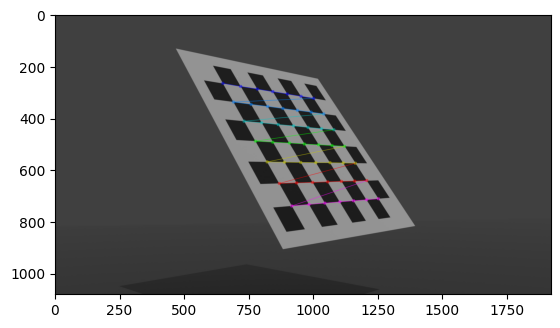

chessboards\c2Left.png


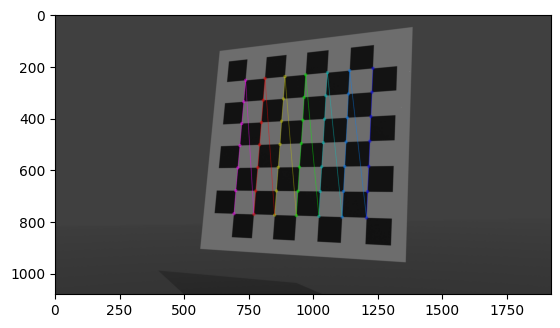

chessboards\c3Left.png


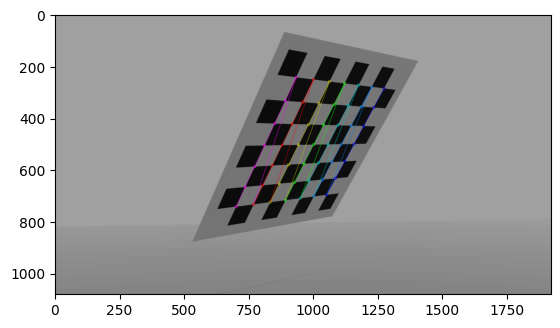

chessboards\c4Left.png


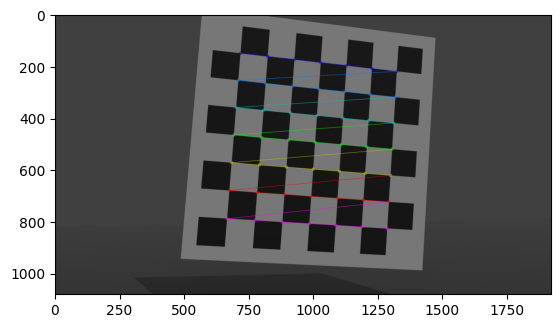

Camera Calibration using chessboard right images:

chessboards\c1Right.png


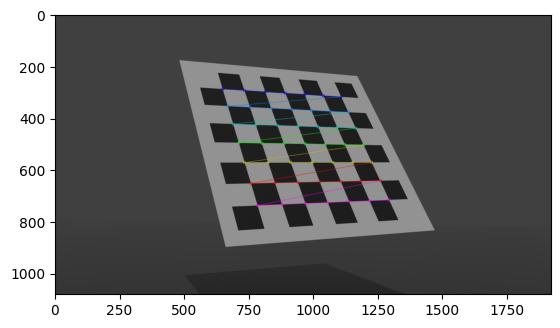

chessboards\c2Right.png


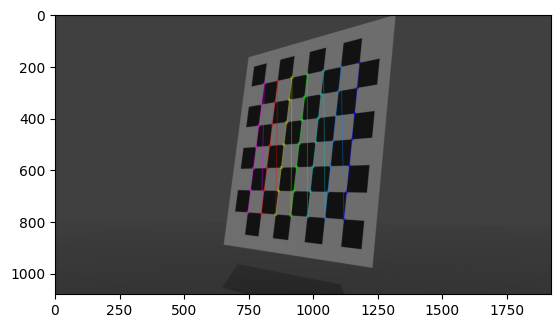

chessboards\c3Right.png


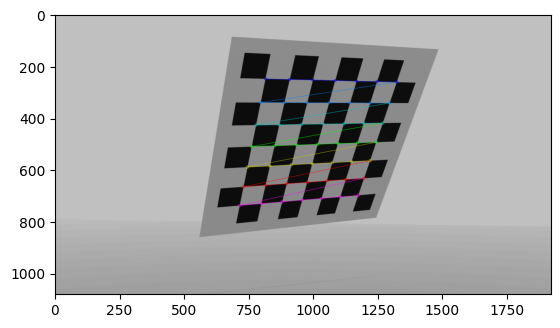

chessboards\c4Right.png


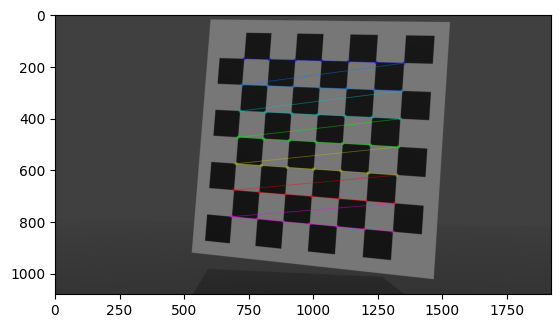

In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calibrate_camera(images, chessboard_size):
    obj_points = []  # Store 3D points of chessboard in real-world space
    img_points = []  # 2D points in image plane
    
    # Prepare object points: (0,0,0), (1,0,0), ...,
    objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
    
    image_size = (1920,1080)
    
    for file in images:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size)
        if ret: # if corners are found
            img_points.append(corners)
            obj_points.append(objp)
            # Termination criteria for the cornerSubPix algorithm
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            # Refine corners location to sub-pixel accuracy for better calibration
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, chessboard_size, corners2, ret)
            print(file)
            plt.imshow(img)
            plt.show()
    
    ret, cameraMatrix, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, image_size, None, None)
    return ret, cameraMatrix, dist, rvecs, tvecs, img_points
    
# Chessboard images location
chessboard_left_images = sorted(glob.glob('chessboards/*Left.png'))
chessboard_right_images = sorted(glob.glob('chessboards/*Right.png'))

chessboard_size = (7, 7) # For an 8x8 chessboard because we specify the number of interior corners

# CAMERA CALIBRATION
print("Camera Calibration using chessboard left images:\n")
retL, cameraMatrixL, distL, rvecsL, tvecsL, imagePointsL  = calibrate_camera(chessboard_left_images, chessboard_size)
print("Camera Calibration using chessboard right images:\n")
retR, cameraMatrixR, distR, rvecsR, tvecsR, imagePointsR = calibrate_camera(chessboard_right_images, chessboard_size)

## Step #2 : Projection Matrices ✅

Next we need to compute the cameras' projection matrices.

In [2]:
def get_projection_matrix(cameraMatrix, rvecs, tvecs):
    R, _ = cv2.Rodrigues(rvecs) # Convert rotation vector to rotation matrix
    extrinsic_matrix = np.hstack((R, tvecs)) # Combine rotation and translation, P = (R T)
    return np.dot(cameraMatrix, extrinsic_matrix) # P = K * (R T)

# Projection matrices
projMatL = get_projection_matrix(cameraMatrixL, rvecsL[0], tvecsL[0])
projMatR = get_projection_matrix(cameraMatrixR, rvecsR[0], tvecsR[0])

print("Projection matrices: \n", projMatL)
print("\n", projMatR)

Projection matrices: 
 [[ 2.06355251e+03  6.06547854e+02 -8.39946715e+02  1.42330411e+04]
 [ 4.65096927e+02  1.43122504e+03  1.56046499e+03  5.87111372e+03]
 [ 7.79216216e-01 -4.01567940e-01  4.81212301e-01  2.19552228e+01]]

 [[ 2.30350682e+03  8.88640312e+01 -1.31769650e+02  1.50558761e+04]
 [ 2.70172867e+02  1.33214469e+03  1.68929698e+03  6.71755030e+03]
 [ 4.77041606e-01 -5.55333433e-01  6.81201941e-01  2.32615876e+01]]


## Step #3 : Fundamental Matrix ✅

Compute fundamental matrix.

In [3]:
def compute_fundamental_matrix(img_points_left, img_points_right):
    # [[(10, 20), (15, 25)], [(30, 40), (35, 45)]] 
    # becomes 
    # [[10, 20], [15, 25], [30, 40], [35, 45]]
    pts_left = np.array([pt.ravel() for pts in img_points_left for pt in pts])
    pts_right = np.array([pt.ravel() for pts in img_points_right for pt in pts])
    
    # Compute the fundamental matrix using corresponding points from the left and right images
    F, mask = cv2.findFundamentalMat(pts_left, pts_right, method=cv2.FM_RANSAC)
    return F, mask
    
F, mask = compute_fundamental_matrix(imagePointsL, imagePointsR)

print("Fundamental Matrix:\n", F)

Fundamental Matrix:
 [[ 4.07852709e-10  7.84673364e-07 -5.09025990e-04]
 [ 8.45744105e-07 -1.05274404e-08 -9.32221537e-03]
 [-5.44381768e-04  7.78379820e-03  1.00000000e+00]]


## Step #4 : Red Lines Sampling ✅

The red lines are sampled for the pairing process.

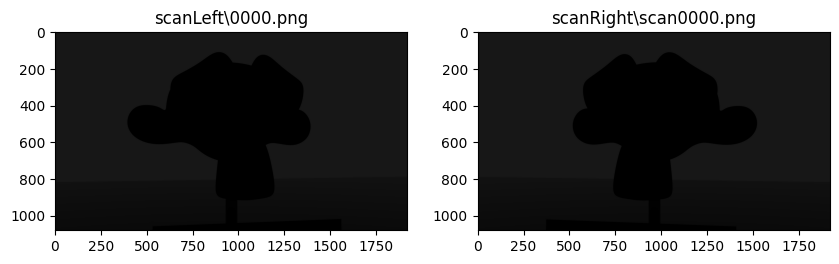

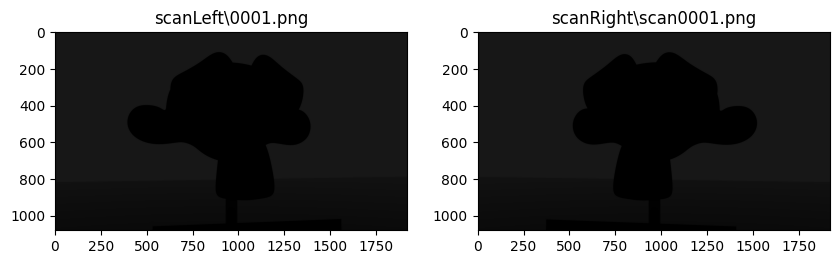

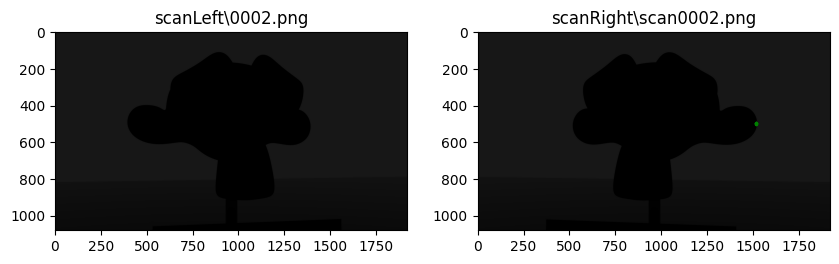

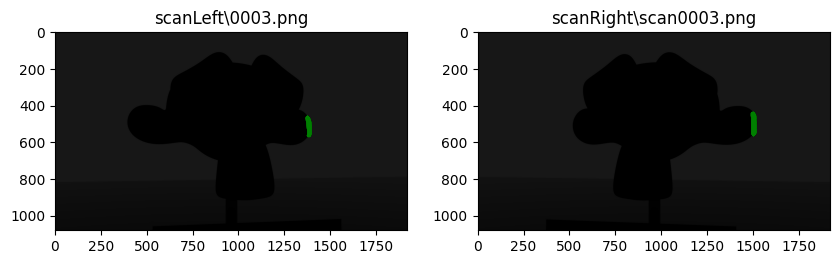

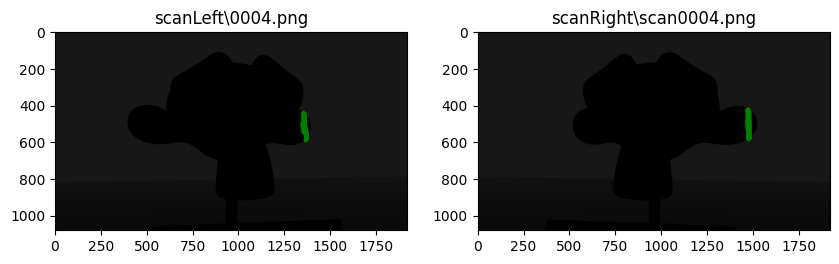

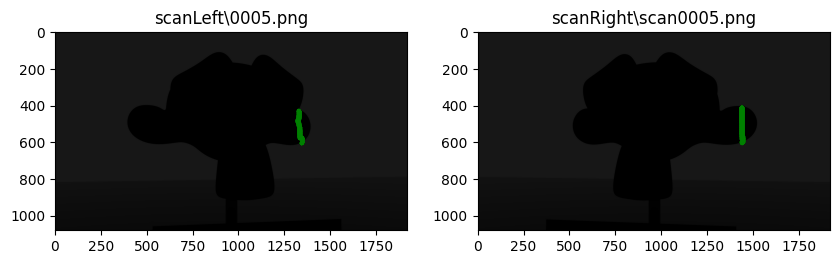

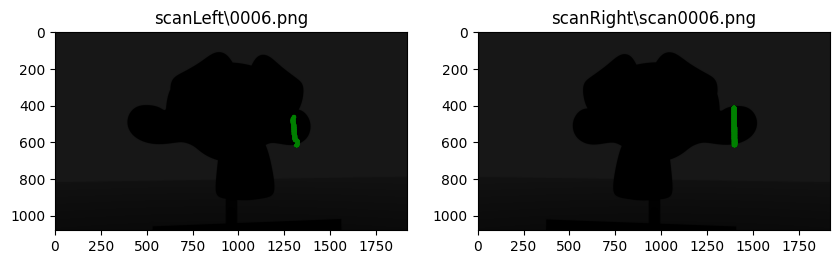

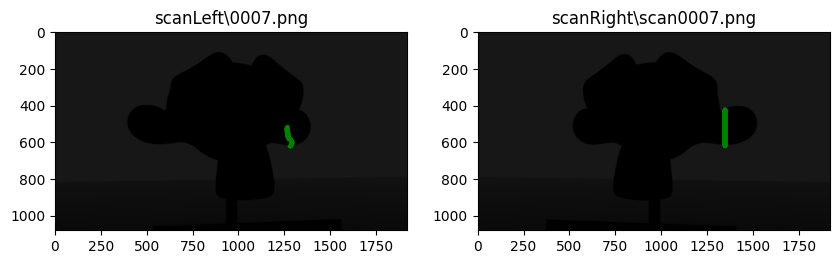

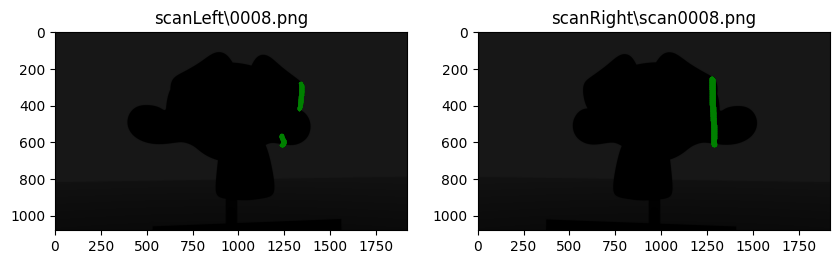

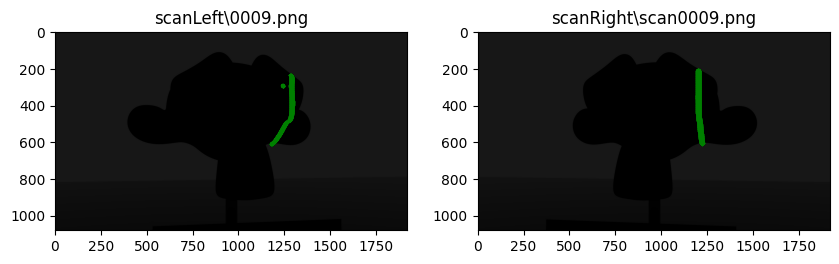

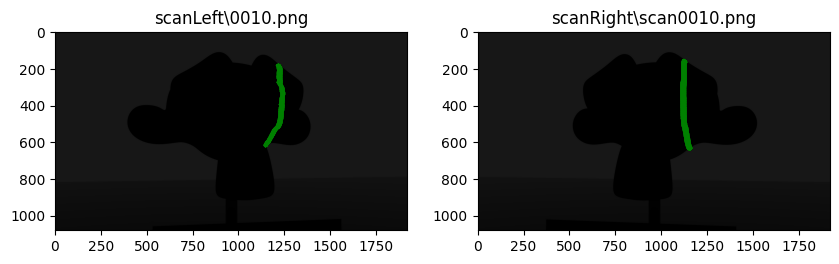

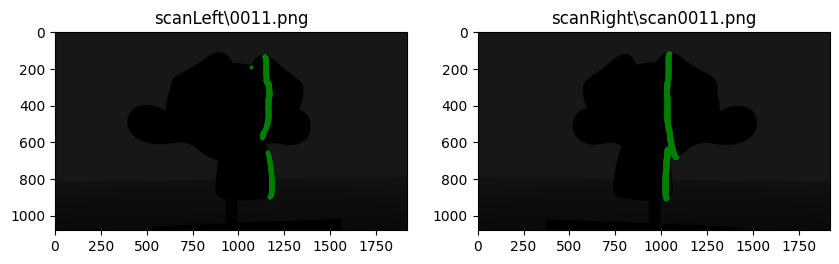

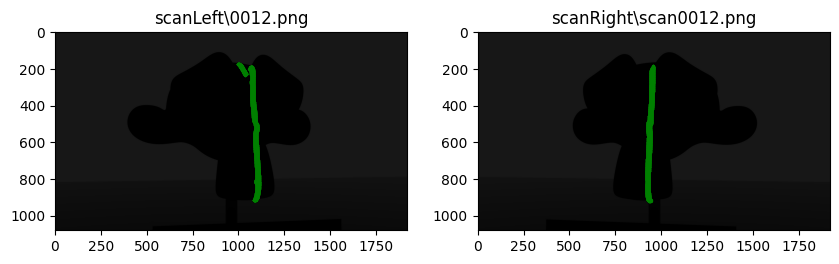

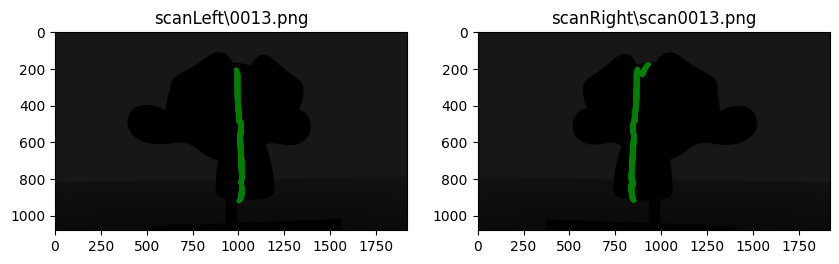

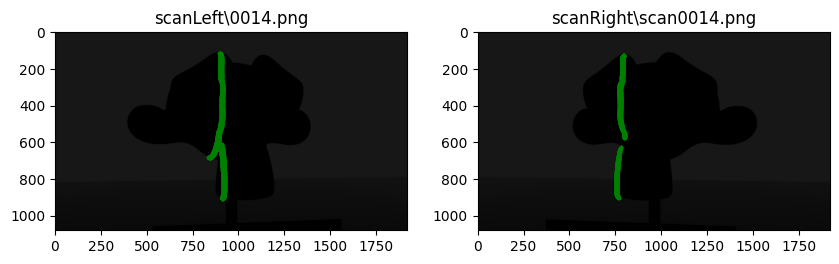

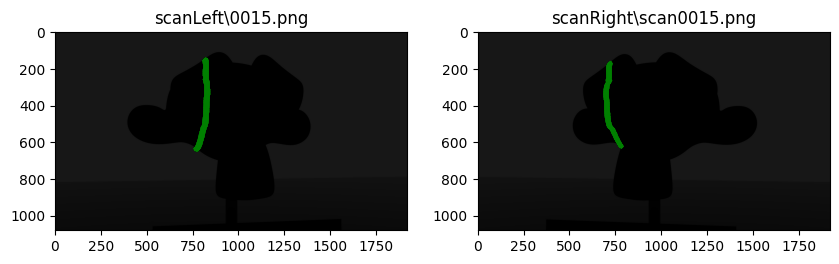

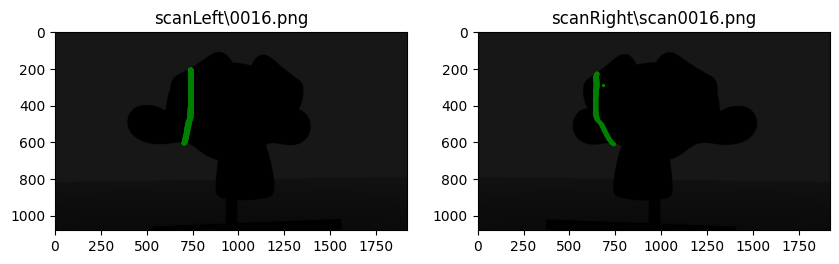

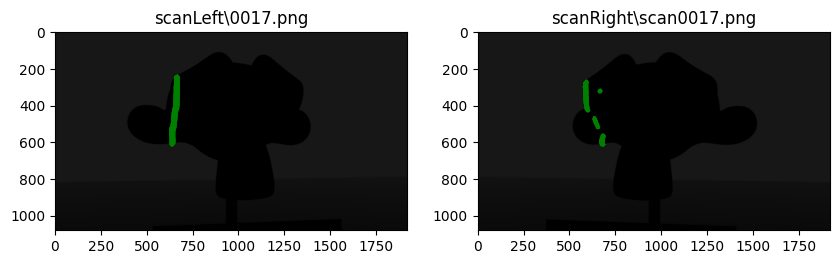

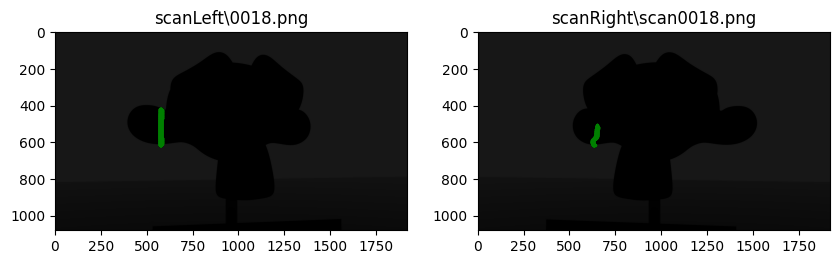

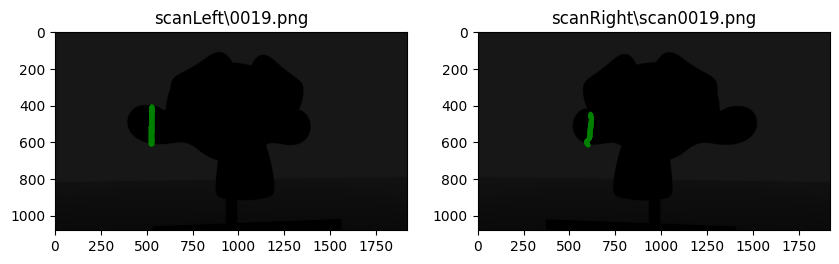

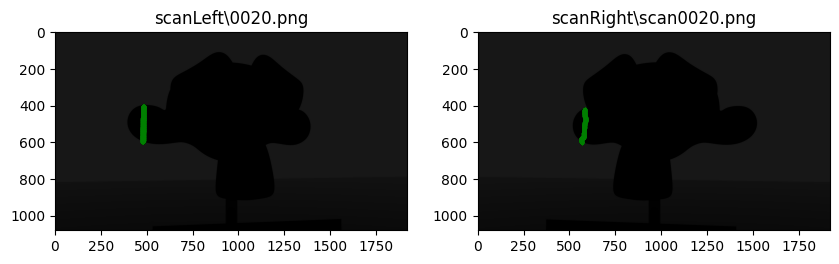

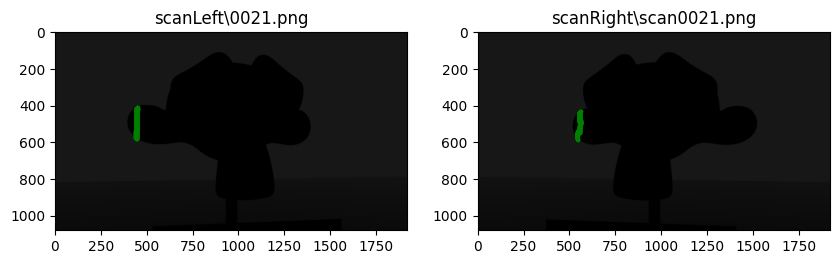

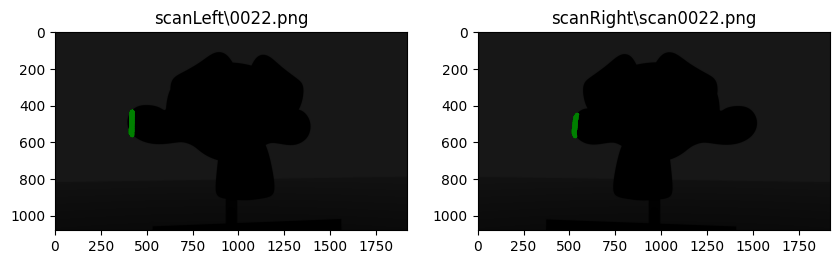

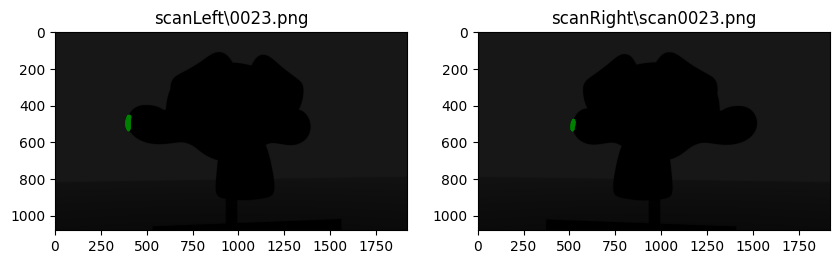

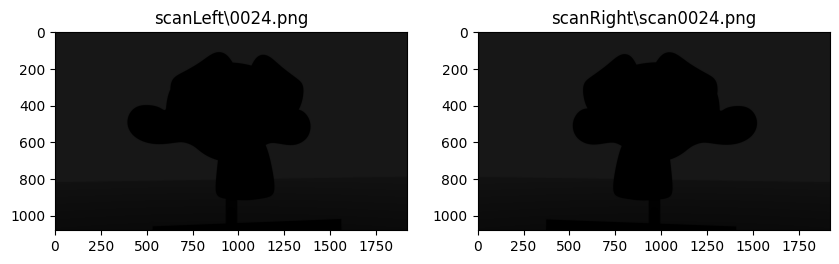

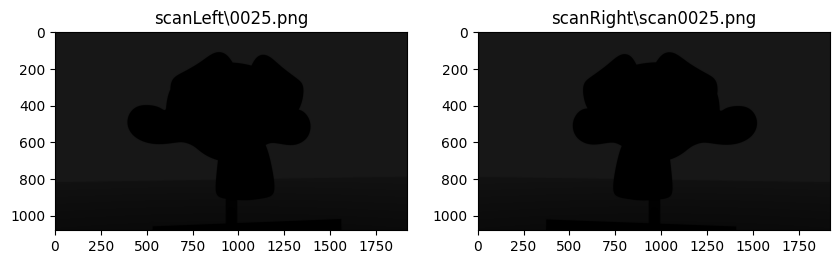

In [4]:
# Monkey images location
monkey_left_images = sorted(glob.glob('scanLeft/*.png'))
monkey_right_images = sorted(glob.glob('scanRight/*.png'))

all_red_points_left = []
all_red_points_right = []

# Extract red pixels coordinates from image
def extract_red_pixels(image):
    # Convert to HSV for better red detection
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define red color ranges
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])
    
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)
    
    # Find non-zero red pixel locations
    red_points = cv2.findNonZero(red_mask)
    if red_points is not None:
        red_points = np.squeeze(red_points)  # Remove unnecessary dimensions
    else:
        red_points = np.array([])  # Return empty array if no red pixels found
    return red_points

# Loop over every image pairs
for left_file, right_file in zip(monkey_left_images, monkey_right_images):
    # Read left and right images
    left_img = cv2.imread(left_file)
    right_img = cv2.imread(right_file)

    # Extract red points
    red_points_left = extract_red_pixels(left_img)
    red_points_right = extract_red_pixels(right_img)

    # Store red points
    all_red_points_left.append(red_points_left)
    all_red_points_right.append(red_points_right)

    # Plot the extracted points
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    if red_points_left.size > 0:
        plt.scatter(red_points_left[:, 0], red_points_left[:, 1], c='green', s=2)
    plt.title(left_file)

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB))
    if red_points_right.size > 0:
        plt.scatter(red_points_right[:, 0], red_points_right[:, 1], c='green', s=2)
    plt.title(right_file)
    plt.show()

## Step #5 : Epipolar Lines ✅

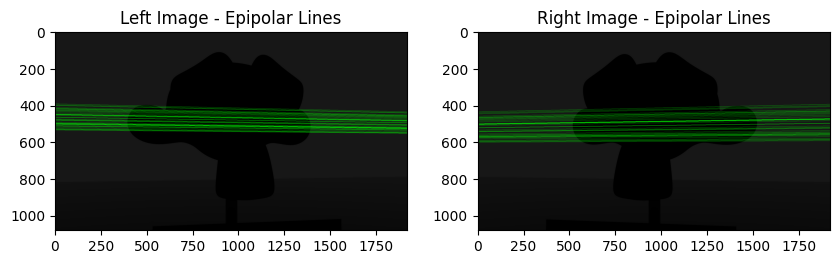

In [5]:
# Compute epipolar lines using fundamental matrix and a set of points
def compute_epipolar_lines(F, points, original_image):
    # Add a column of ones to make points homogeneous (2D to 3D)
    points_h = np.hstack((points, np.ones((points.shape[0], 1))))
    
    # Compute epipolar lines (l = Fx)
    lines = np.dot(F, points_h.T).T  # Each row corresponds to a line [a, b, c] in ax + by + c = 0
    
    # draw lines on the original image
    overlay_image = original_image.copy()
    for line in lines:
        a, b, c = line
        x1, y1 = 0, int(-c / b)  # Line intersects y-axis (x=0)
        x2, y2 = original_image.shape[1], int((-c - a * original_image.shape[1]) / b)  # Line intersects at x=image width
        cv2.line(overlay_image, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Draw a green line with thickness 1
    
    return lines, overlay_image

# Compute epipolar lines for the 5th image pair
points_left = all_red_points_left[5]
points_right = all_red_points_right[5]

if points_left.size > 0 and points_right.size > 0:
    # Number of epipolar lines
    num_points_to_sample = 40
    if points_left.shape[0] > num_points_to_sample:
        sampled_indices = np.random.choice(points_left.shape[0], num_points_to_sample, replace=False)
        points_left = points_left[sampled_indices]
        points_right = points_right[sampled_indices]
        
    lines_left, line_img_left = compute_epipolar_lines(F.T, points_right, left_img)
    lines_right, line_img_right = compute_epipolar_lines(F, points_left, right_img)
    
    # Plot epipolar lines
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(line_img_left, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title("Left Image - Epipolar Lines")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(line_img_right, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title("Right Image - Epipolar Lines")
    plt.show()

## Step #6 : Matching Pairs ✅

Image Pair: scanLeft\0000.png and scanRight\scan0000.png
Number of matching pairs found: 40


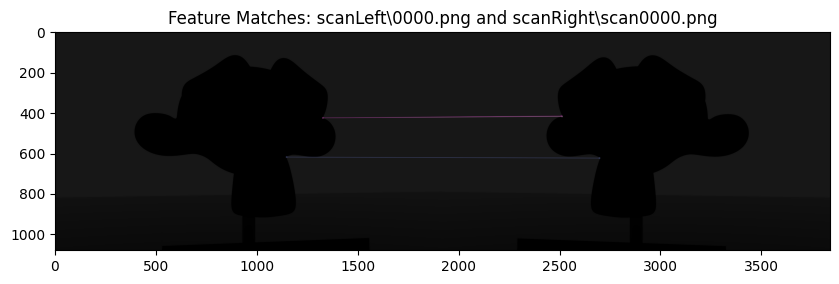

Image Pair: scanLeft\0001.png and scanRight\scan0001.png
Number of matching pairs found: 40


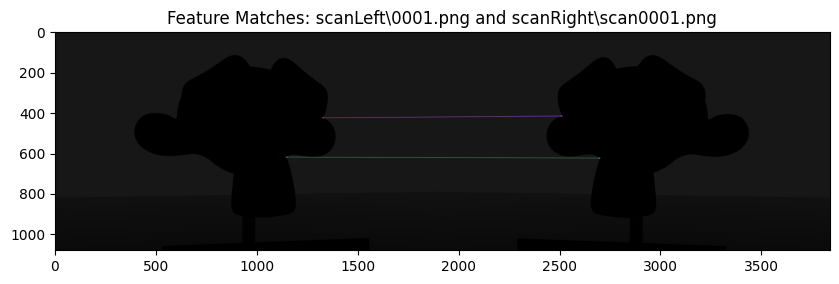

Image Pair: scanLeft\0002.png and scanRight\scan0002.png
Number of matching pairs found: 40


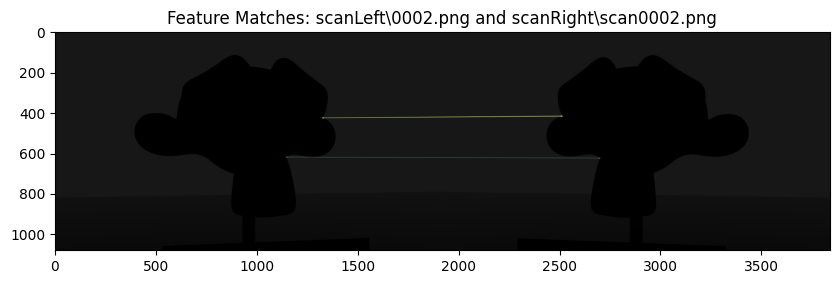

Image Pair: scanLeft\0003.png and scanRight\scan0003.png
Number of matching pairs found: 40


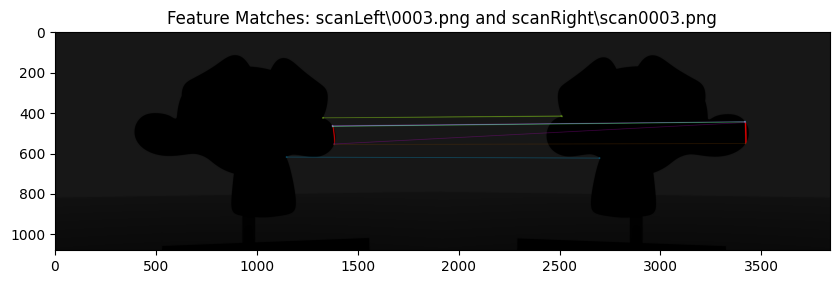

Image Pair: scanLeft\0004.png and scanRight\scan0004.png
Number of matching pairs found: 40


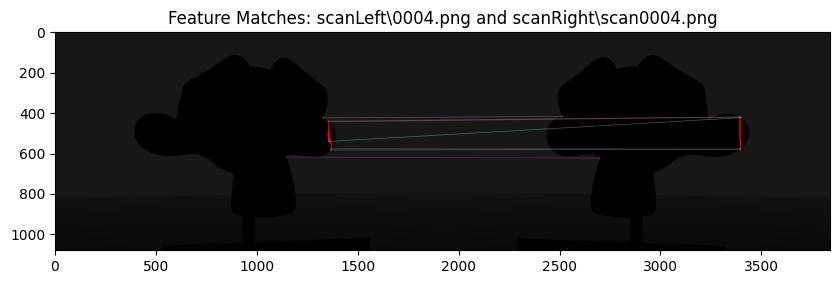

Image Pair: scanLeft\0005.png and scanRight\scan0005.png
Number of matching pairs found: 40


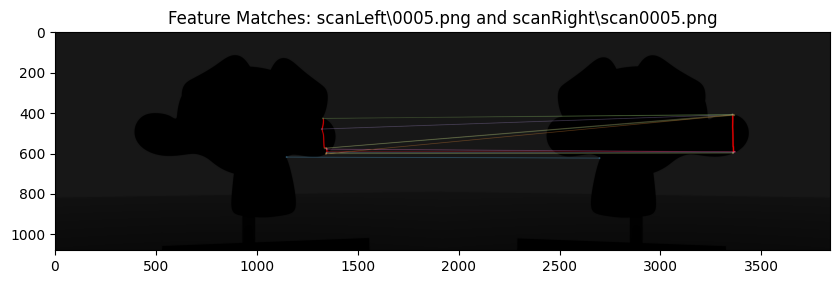

Image Pair: scanLeft\0006.png and scanRight\scan0006.png
Number of matching pairs found: 40


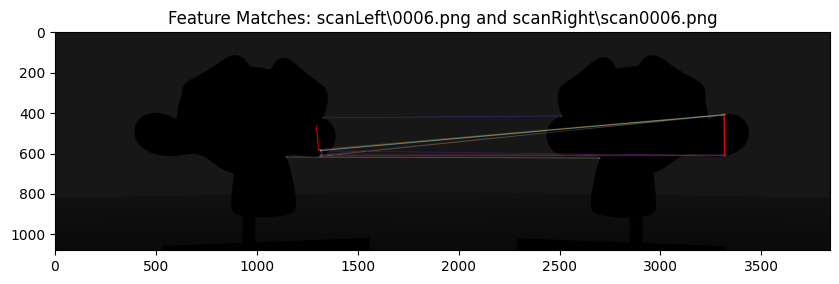

Image Pair: scanLeft\0007.png and scanRight\scan0007.png
Number of matching pairs found: 40


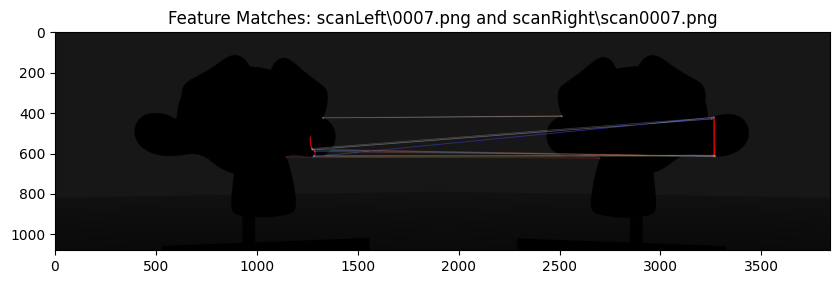

Image Pair: scanLeft\0008.png and scanRight\scan0008.png
Number of matching pairs found: 40


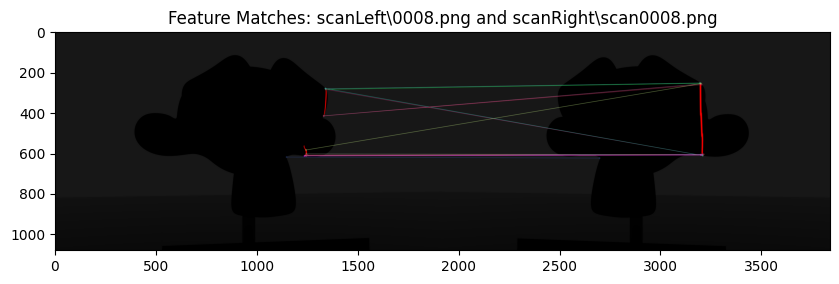

Image Pair: scanLeft\0009.png and scanRight\scan0009.png
Number of matching pairs found: 40


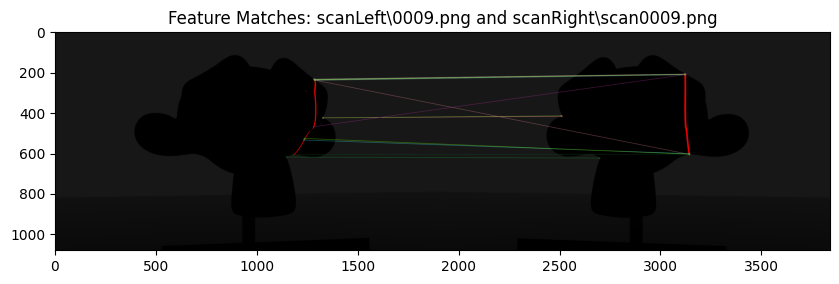

Image Pair: scanLeft\0010.png and scanRight\scan0010.png
Number of matching pairs found: 40


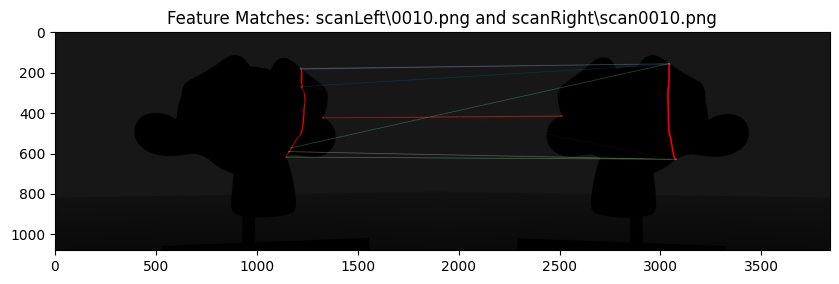

Image Pair: scanLeft\0011.png and scanRight\scan0011.png
Number of matching pairs found: 40


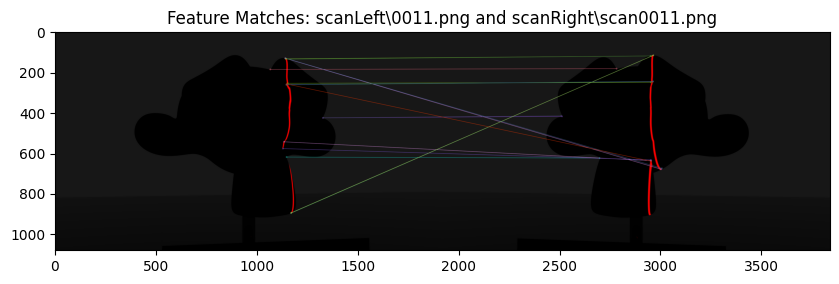

Image Pair: scanLeft\0012.png and scanRight\scan0012.png
Number of matching pairs found: 40


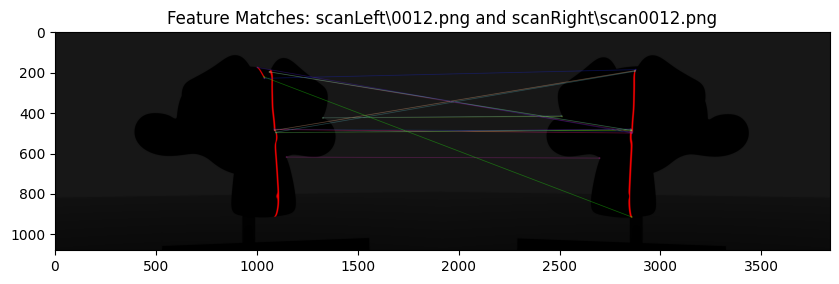

Image Pair: scanLeft\0013.png and scanRight\scan0013.png
Number of matching pairs found: 40


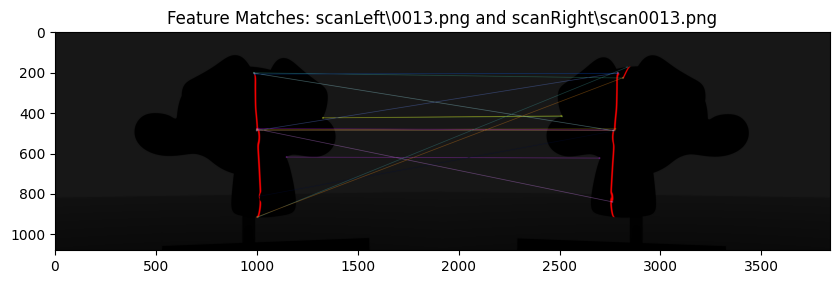

Image Pair: scanLeft\0014.png and scanRight\scan0014.png
Number of matching pairs found: 40


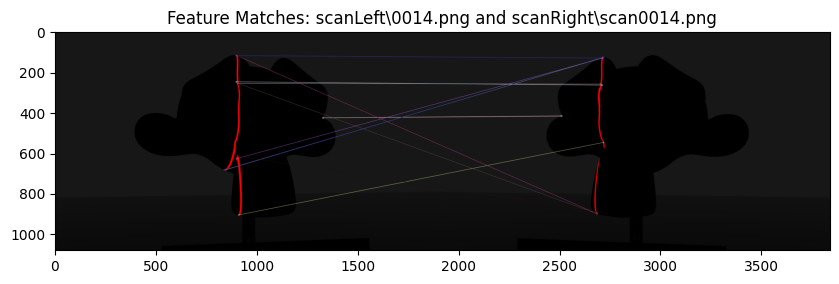

Image Pair: scanLeft\0015.png and scanRight\scan0015.png
Number of matching pairs found: 40


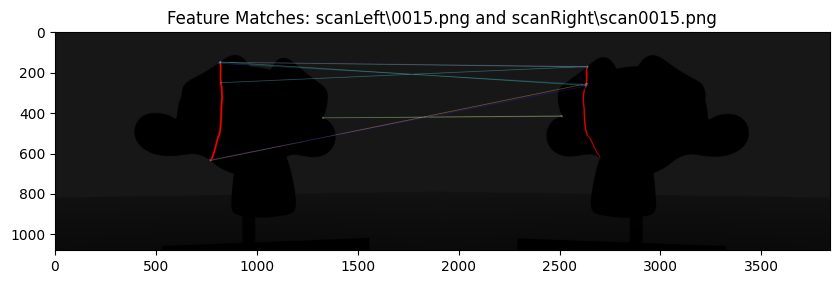

Image Pair: scanLeft\0016.png and scanRight\scan0016.png
Number of matching pairs found: 40


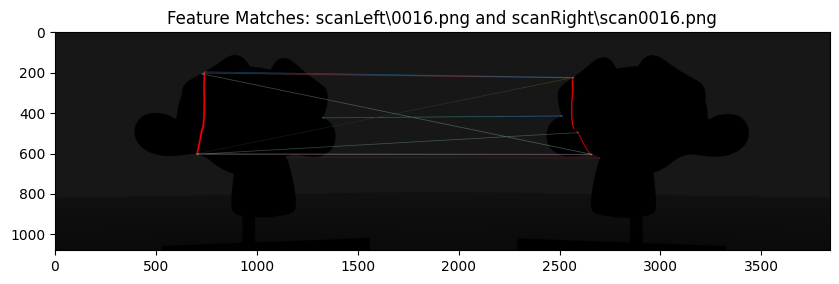

Image Pair: scanLeft\0017.png and scanRight\scan0017.png
Number of matching pairs found: 40


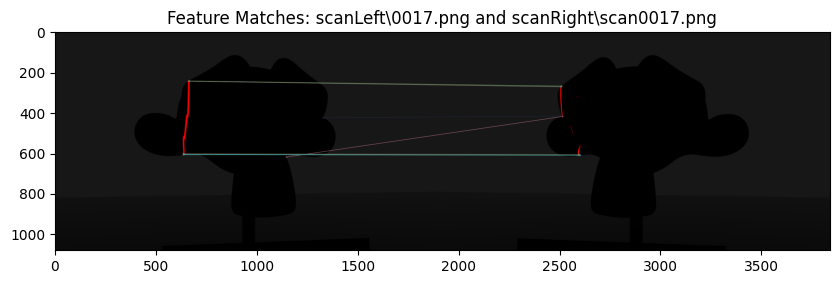

Image Pair: scanLeft\0018.png and scanRight\scan0018.png
Number of matching pairs found: 40


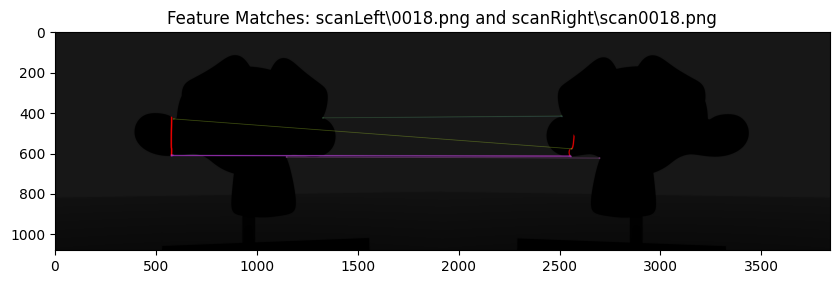

Image Pair: scanLeft\0019.png and scanRight\scan0019.png
Number of matching pairs found: 40


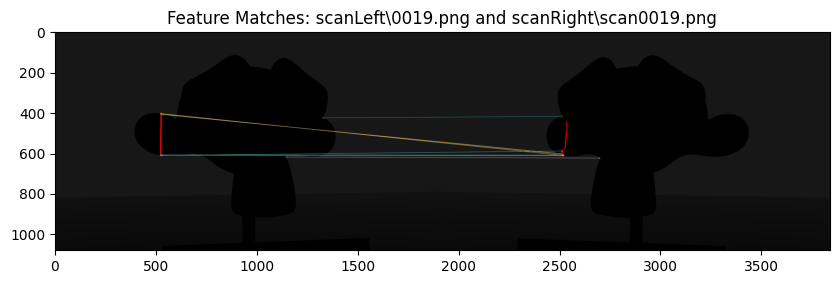

Image Pair: scanLeft\0020.png and scanRight\scan0020.png
Number of matching pairs found: 40


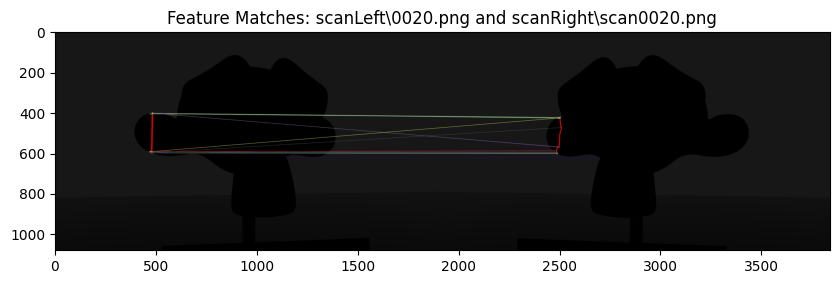

Image Pair: scanLeft\0021.png and scanRight\scan0021.png
Number of matching pairs found: 40


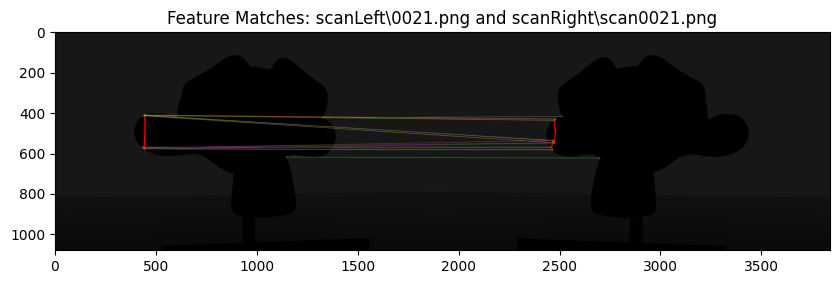

Image Pair: scanLeft\0022.png and scanRight\scan0022.png
Number of matching pairs found: 40


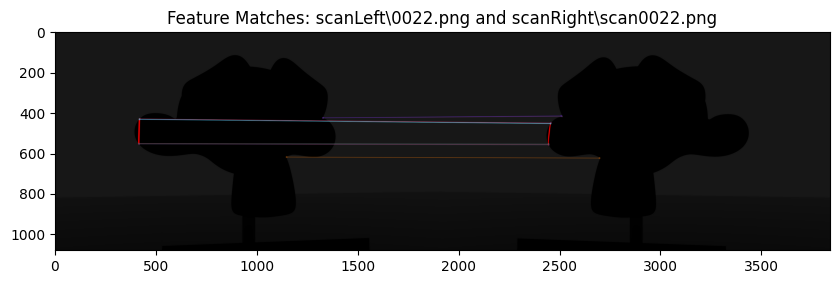

Image Pair: scanLeft\0023.png and scanRight\scan0023.png
Number of matching pairs found: 40


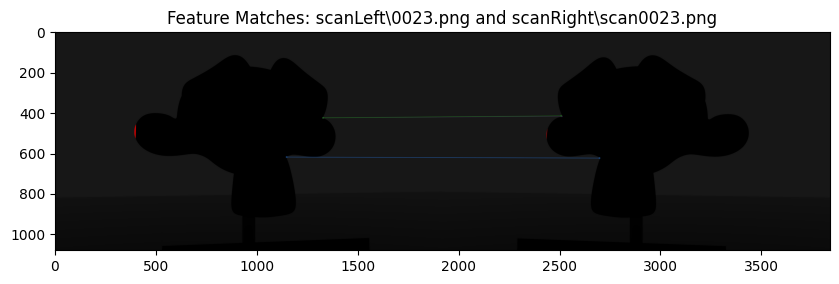

Image Pair: scanLeft\0024.png and scanRight\scan0024.png
Number of matching pairs found: 40


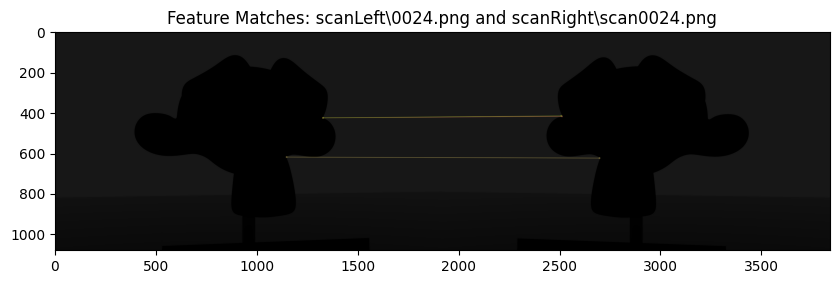

Image Pair: scanLeft\0025.png and scanRight\scan0025.png
Number of matching pairs found: 40


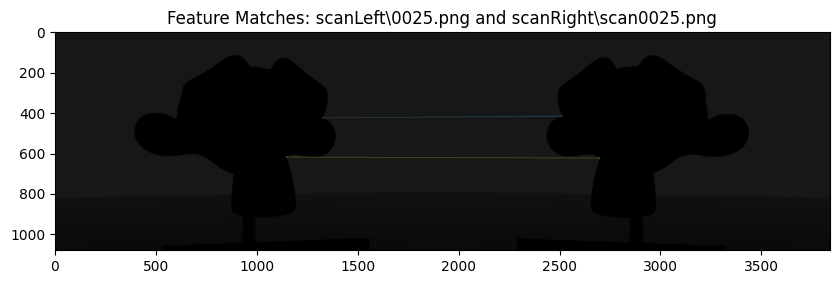

In [6]:
# Initialize ORB detector
orb = cv2.ORB_create(nfeatures=5000)

# Loop through all pairs of images
for left_file, right_file in zip(monkey_left_images, monkey_right_images):
    left_image = cv2.imread(left_file)
    right_image = cv2.imread(right_file)
    
    # Detect keypoints and compute descriptors
    # keypoints: points of interest (corner or edge)
    # descriptors: feature vectors describing the neighborhood around each keypoint
    keypoints_left, descriptors_left = orb.detectAndCompute(left_image, None)
    keypoints_right, descriptors_right = orb.detectAndCompute(right_image, None)
    
    # Check if descriptors are valid (skip the pair if one of them is empty)
    if descriptors_left is None or descriptors_right is None:
        print(f"Skipping image pair: {left_file}, {right_file} (no descriptors found)")
        continue
    
    # Match descriptors
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors_left, descriptors_right)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Extract matched points
    matches_points_left = np.float32([keypoints_left[m.queryIdx].pt for m in matches])
    matches_points_right = np.float32([keypoints_right[m.trainIdx].pt for m in matches])
    
    print(f"Image Pair: {left_file} and {right_file}")
    print(f"Number of matching pairs found: {len(points_left)}")
    
    # Visualize matches (only top 50 matches for clarity)
    match_image = cv2.drawMatches(left_image, keypoints_left, right_image, keypoints_right, matches[:50], None, flags=2)
    
    # Display the match visualization
    plt.figure(figsize=(10, 5))
    plt.title(f"Feature Matches: {left_file} and {right_file}")
    plt.imshow(cv2.cvtColor(match_image, cv2.COLOR_BGR2RGB))
    plt.show()

## Step #7 : Triangulate 3D points ✅

In [7]:
# Triangulate 3D points from matching 2D points in stereo images.
def triangulate_points(projMatL, projMatR, points_left, points_right):
    # Convert points to homogeneous format
    points_left_h = np.vstack((points_left.T, np.ones((1, points_left.shape[0]))))
    points_right_h = np.vstack((points_right.T, np.ones((1, points_right.shape[0]))))
    
    # Perform triangulation
    points_triangulated = cv2.triangulatePoints(projMatL, projMatR, points_left_h[:2], points_right_h[:2])
    
    # Convert from homogeneous to 3D coordinates
    points_3d = cv2.convertPointsFromHomogeneous(points_triangulated.T)[:, 0, :]
    return points_3d

all_points_3d = []

# Loop through all pairs of images
for left_file, right_file in zip(monkey_left_images, monkey_right_images):
    left_image = cv2.imread(left_file)
    right_image = cv2.imread(right_file)
    
    keypoints_left, descriptors_left = orb.detectAndCompute(left_image, None)
    keypoints_right, descriptors_right = orb.detectAndCompute(right_image, None)
    
    # Check if descriptors are valid (skip the pair if one of them is empty)
    if descriptors_left is None or descriptors_right is None:
        print(f"Skipping image pair: {left_file}, {right_file} (no descriptors found)")
        continue
    
    # Match descriptors
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors_left, descriptors_right)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Extract matched points
    matches_points_left = np.float32([keypoints_left[m.queryIdx].pt for m in matches])
    matches_points_right = np.float32([keypoints_right[m.trainIdx].pt for m in matches])
    
    if len(matches_points_left) < 8:  # Ensure sufficient matches for triangulation
        print(f"Skipping triangulation for image pair: {left_file}, {right_file} (not enough matches)")
        continue
    
    # Triangulate 3D points
    points_3d = triangulate_points(projMatL, projMatR, matches_points_left, matches_points_right)
    all_points_3d.append(points_3d)
    
print("All points 3D:\n", all_points_3d)

Skipping triangulation for image pair: scanLeft\0000.png, scanRight\scan0000.png (not enough matches)
Skipping triangulation for image pair: scanLeft\0001.png, scanRight\scan0001.png (not enough matches)
Skipping triangulation for image pair: scanLeft\0002.png, scanRight\scan0002.png (not enough matches)
Skipping triangulation for image pair: scanLeft\0023.png, scanRight\scan0023.png (not enough matches)
Skipping triangulation for image pair: scanLeft\0024.png, scanRight\scan0024.png (not enough matches)
Skipping triangulation for image pair: scanLeft\0025.png, scanRight\scan0025.png (not enough matches)
All points 3D:
 [array([[-4.07777104,  8.1152854 , -6.6650292 ],
       [-1.64984294,  7.33183709, -3.632302  ],
       [-4.10648305,  8.12365463, -6.6846699 ],
       [ 8.98920647,  3.66809431, -1.87498704],
       [ 8.9939952 ,  3.61386599, -1.87710545],
       [ 8.8923637 ,  4.22298985, -1.65211728],
       [ 8.97305409,  3.65492173, -1.88609622],
       [ 9.00405243,  3.63060993, -

## Step #8 : 3D points cloud ❌

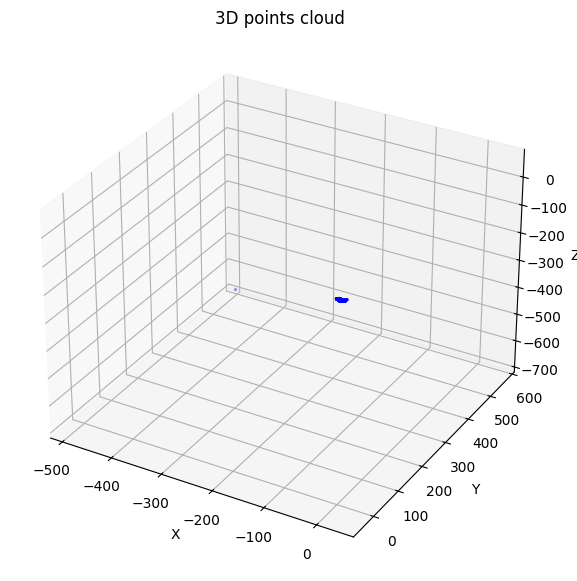

In [9]:
def display_point_cloud(points_3d):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], s=2, c='blue')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title("3D points cloud")
    plt.show()
    
# Combine all 3D points into a single array
all_points_3d = np.vstack(all_points_3d)

# Display the 3D points cloud
display_point_cloud(all_points_3d)